# HOMEWORK PART 2-b

---

I've included in your emails MATLAB/Python code for solving (i) A reaction-diffusion system of equations,and (ii) The Kuramoto-Sivashinsky (KS) equation.

3. For the reaction-diffusion system, first project to a low-dimensional subspace via the SVD and see how forecasting works in the low-rank variables using a NN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

from tabulate import tabulate

from tensorflow import keras
from keras import layers

Mounted at /content/drive


In [5]:
dt = 0.05
tmax = 10
t = np.linspace(0, tmax, int(tmax/dt)+1)
d1 = 0.1
d2 = 0.1 
beta = 1.0
L = 20 
n = 32
N = n * n
x2 = np.linspace(-L/2, L/2, n+1) 
x = x2[0: n]
y = x
kx = (2 * np.pi / L) * np.concatenate([np.arange(0, n/2), np.arange(-n/2, 0)])
ky = kx

# Initial conditions
[X, Y] = np.meshgrid(x, y)
[KX, KY] = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N,1))

m = 1 # number of spirals

u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j*Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j*Y) - (np.sqrt(X ** 2 + Y ** 2)))
    
# Reaction diffusion
uvt = np.concatenate([np.reshape(np.fft.fft2(u[:, :, 0]).T, (N, 1)), np.reshape(np.fft.fft2(v[:, :, 0]).T, (N, 1))])
sol = solve_ivp(reaction_diffusion, [0, tmax], uvt[:, 0], args=(K22, d1, d2, beta, n, N), t_eval=t, method = 'RK45')
uvsol = sol.y

for j in range(len(t)-1):
    ut = np.reshape(uvsol[:N,j+1], (n, n))
    vt = np.reshape(uvsol[N:,j+1], (n, n))
    u[:, :, j+1] = np.real(np.fft.ifft2(ut))
    v[:, :, j+1] = np.real(np.fft.ifft2(vt))

table = [["ut", ut.shape[0], ut.shape[1], 'None'],
        ["vt", vt.shape[0], vt.shape[1], 'None'],
        ["u", u.shape[0], u.shape[1], u.shape[2]],
        ["v", v.shape[0], v.shape[1], v.shape[2]]]

print(tabulate(table, headers=["","x-dim", "y-dim", "z-dim"], tablefmt="github"))

|    |   x-dim |   y-dim | z-dim   |
|----|---------|---------|---------|
| ut |      32 |      32 | None    |
| vt |      32 |      32 | None    |
| u  |      32 |      32 | 201     |
| v  |      32 |      32 | 201     |


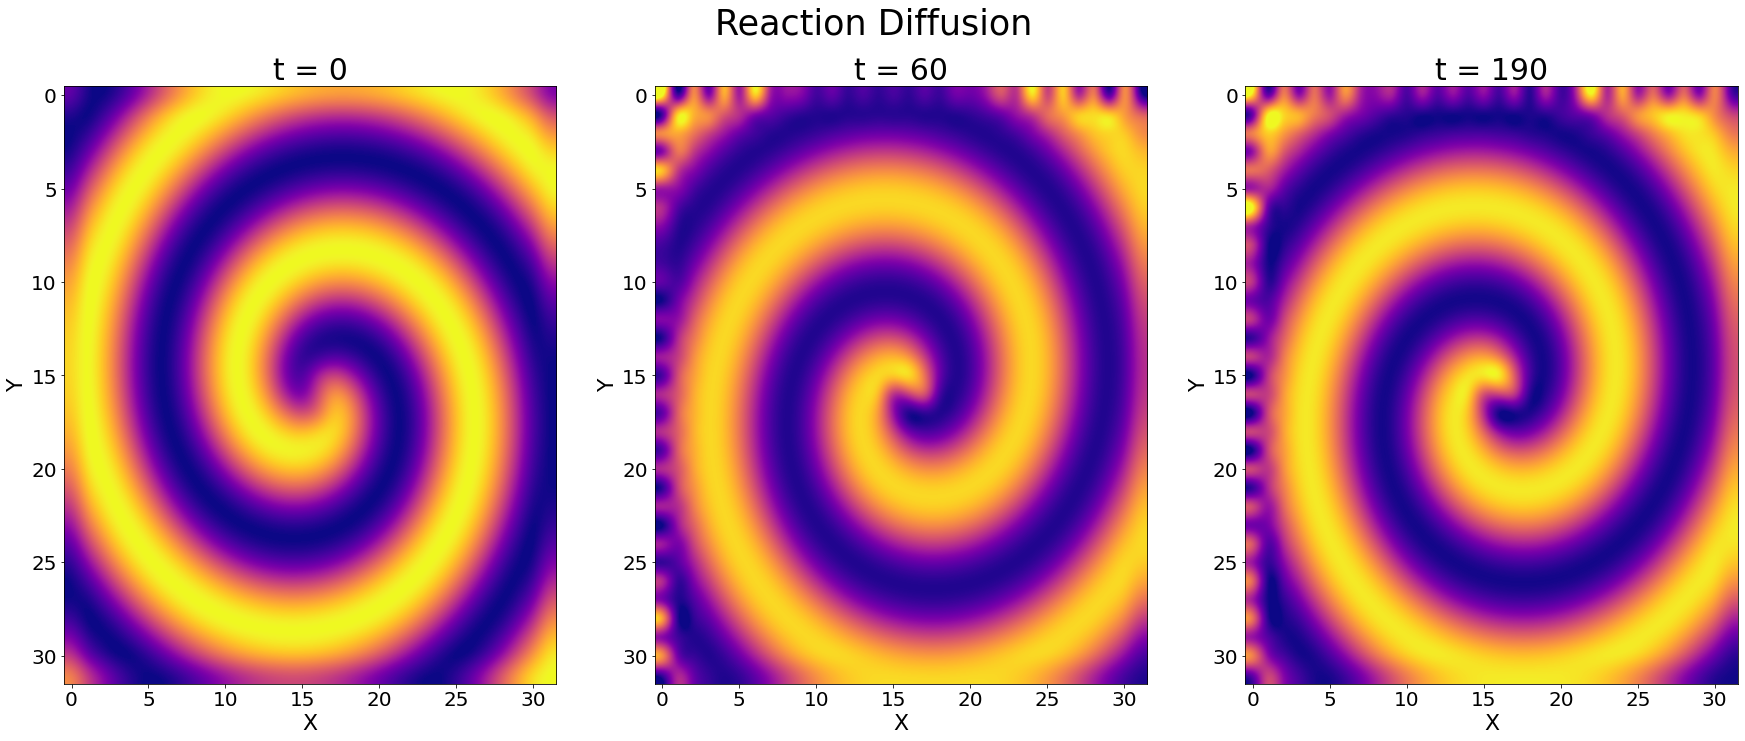

In [6]:
fig= plt.figure(figsize=(30, 11))
plt.suptitle('Reaction Diffusion', fontsize = 35)

ax = fig.add_subplot(1,3,1)
h = ax.imshow(u[:, :, 0], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title('t = 0', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = fig.add_subplot(1,3,2)
h = ax.imshow(u[:, :, 60], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title('t = 60', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = fig.add_subplot(1,3,3)
h = ax.imshow(u[:, :, 190], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title('t = 190', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()

## Let's build the reduced low-dimensional subspace via the SVD and than build the NET

In [22]:
n_time = int(v.shape[2] * 0.2)
v_res = np.reshape(v, (v.shape[0] ** 2, v.shape[2]))

X = np.copy(v_res)

U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T

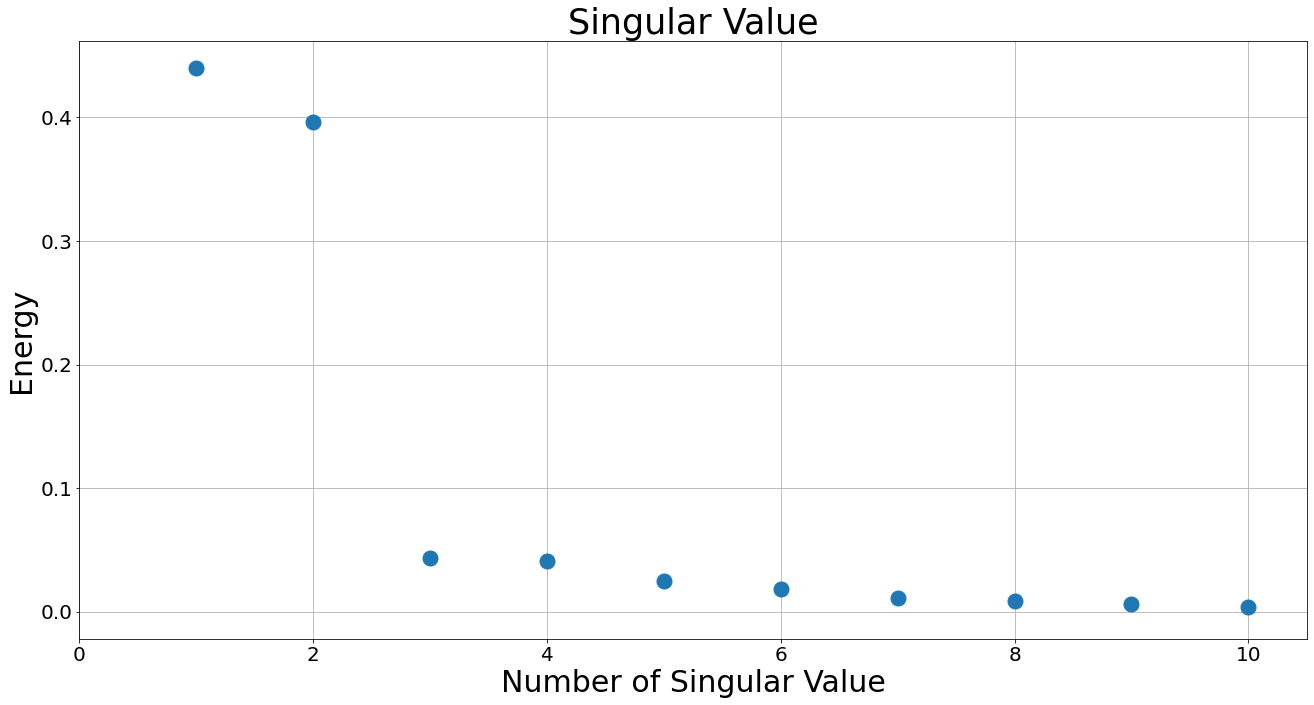

In [23]:
fig = plt.figure(figsize=(22, 11))
ax = fig.add_subplot(111)
ax.plot(range(1,len(S)+1), S / np.sum(S), 'o', linewidth='2', markersize=15)
ax.set_title('Singular Value', fontsize = 35)
ax.set_xlabel('Number of Singular Value', fontsize = 30)
ax.set_ylabel('Energy', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlim([0, 10.5])
plt.grid()
plt.show()

## We will consider 7 modes for the reduction

In [31]:
m = 7

Ur = U[:, :m]
Vr = V[:, :m]
Sr = S[:m]

X_reduced = Ur.conj().T @ X
X_reduced_ = X_reduced[:, :-1]
X_reduced_shifted =  X_reduced[:, 1:]

X_train = X_reduced_[:, :-n_time].T
X_train_shifted = X_reduced_shifted[:, 1:-n_time+1].T

X_test = X_reduced_[:, -n_time:-1].T
X_test_shifted = X_reduced_shifted[:,-n_time+1:].T

In [ ]:
NN = keras.models.Sequential()
NN.add(layers.Dense(10, input_dim = X_train.shape[1], activation='sigmoid', name='Input'))
NN.add(layers.Dense(32, activation='relu', name = 'middle-1'))
NN.add(layers.Dense(32, activation='softmax', name = 'middle-2'))
NN.add(layers.Dense(X_train.shape[1], activation='linear', name = 'Output'))

NN.compile(loss='mse', optimizer='adam')

History = NN.fit(X_train, X_train_shifted, epochs=5000, verbose = 1) 

In [33]:
prediction = np.copy(X_test)

prediction = NN.predict(X_test)

In [47]:
_prediction = Ur @ prediction.T
_real = Ur @ X_test.T
NNprediction = np.reshape(_prediction, (v.shape[0], v.shape[0], -1))
real = np.reshape(_real, (v.shape[0], v.shape[0], -1))

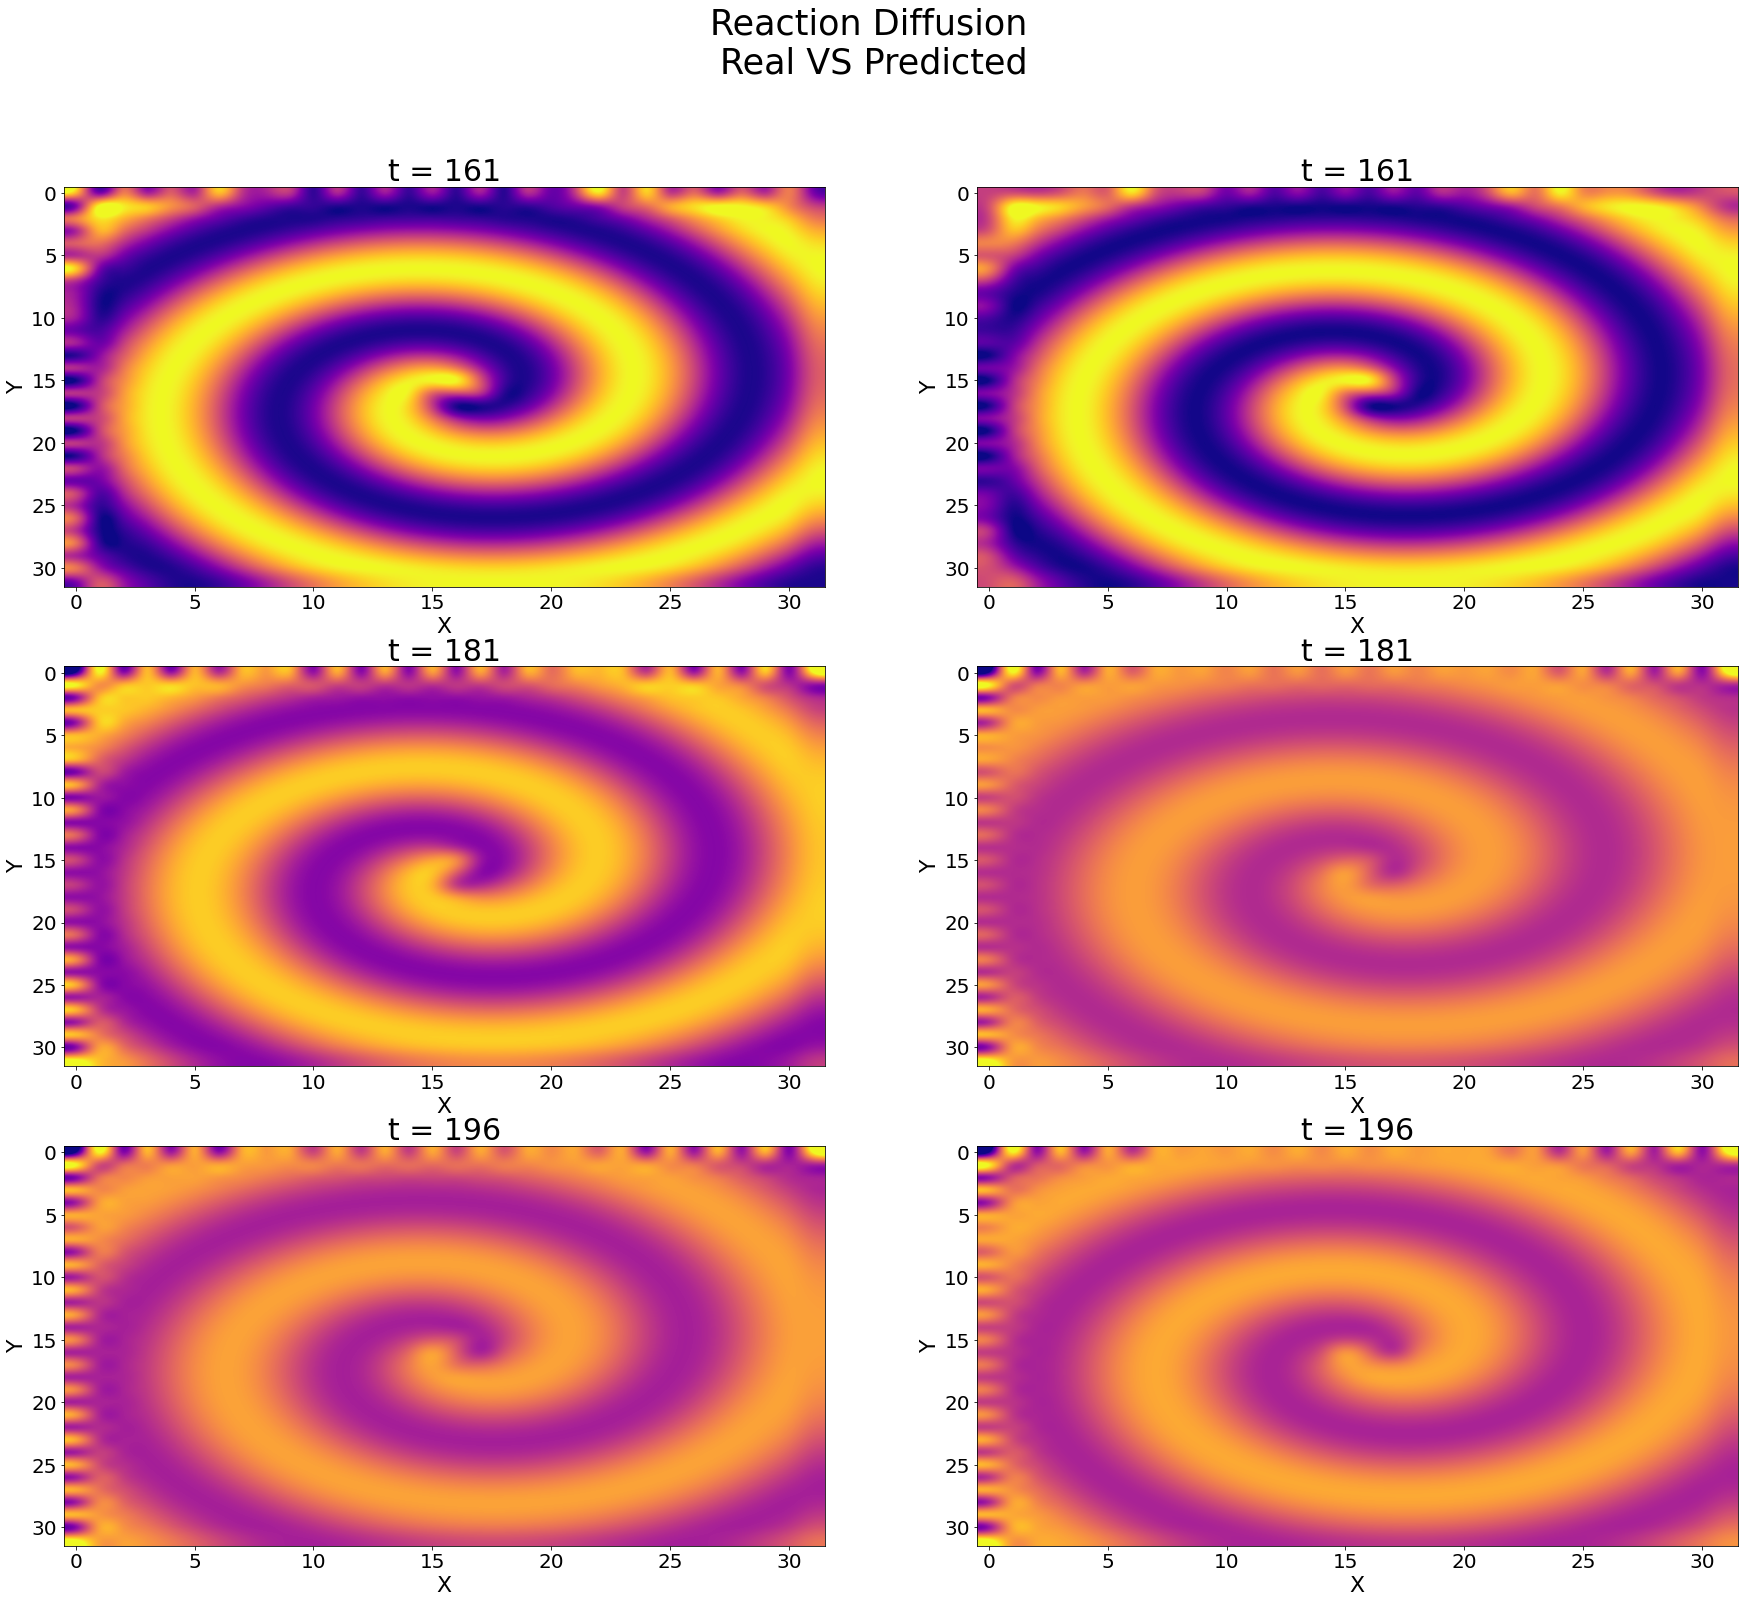

In [49]:
time_recon = len(t) - n_time

fig= plt.figure(figsize=(30, 25))
plt.suptitle('Reaction Diffusion \nReal VS Predicted', fontsize = 35)

ax = fig.add_subplot(3,2,1)
h = ax.imshow(real[:, :, 0], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title(f't = {time_recon + 0}', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = fig.add_subplot(3,2,2)
h = ax.imshow(NNprediction[:, :, 0], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title(f't = {time_recon + 0}', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = fig.add_subplot(3,2,3)
h = ax.imshow(real[:, :, 20], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title(f't = {time_recon + 20}', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = fig.add_subplot(3,2,4)
h = ax.imshow(NNprediction[:, :, 20], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title(f't = {time_recon + 20}', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = fig.add_subplot(3,2,5)
h = ax.imshow(real[:, :, 35], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title(f't = {time_recon + 35}', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = fig.add_subplot(3,2,6)
h = ax.imshow(NNprediction[:, :, 35], cmap='plasma', interpolation='spline36', aspect='auto')
ax.set_xlabel('X', fontsize = 22)
ax.set_ylabel('Y', fontsize = 22)
ax.set_title(f't = {time_recon + 35}', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()